# Initialise

In [2]:
#! /usr/bin/env python

'''
Trains 7D QuaLiKiz-NN with a single output (efiTG)
'''

from __future__ import print_function

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, adam, Adam
from keras.initializers import TruncatedNormal
from keras import regularizers
from keras import backend as K
import pandas
import numpy
import sys
import os

# Define new Metric: rmse = Root Mean Square Error
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square( y_true-y_pred )))

# Gets the current file name. Useful for procedurally generating output/log files.
file_name =  os.path.basename(sys.argv[0][:-3])

# Define neural network parameters
batch_size = 10
#num_classes = 1
epochs = 100

# Load Data (which is in HDF5 or .h5 format)
store = pandas.HDFStore("../IPP-Neural-Networks/unstable_training_gen2_7D_nions0_flat_filter7.h5")
target_df = store['efeETG_GB'].to_frame()  # This one is relatively easy to train
input_df = store['input']


Using TensorFlow backend.


In [3]:
# Puts inputs and outputs in the same pandas dataframe.
# Also only keeps overlapping entries.
joined_dataFrame = target_df.join(input_df)

'''
# Remove all negative values
joined_dataFrame = joined_dataFrame[(joined_dataFrame['efeETG_GB']>0)
        & (joined_dataFrame['Ati']>0)
        & (joined_dataFrame['Ate']>0)
        & (joined_dataFrame['An']>0)
        & (joined_dataFrame['qx']>0)
        & (joined_dataFrame['smag']>0)
        & (joined_dataFrame['x']>0)
        & (joined_dataFrame['Ti_Te']>0)]
'''

# Shuffles dataset
shuffled_joined_dataFrame = joined_dataFrame.reindex(numpy.random.permutation(
                                                joined_dataFrame.index))

print(shuffled_joined_dataFrame.max())

# Normalizes data (no standardization necessary due to dataset design)
shuffled_joined_dataFrame_normalized = shuffled_joined_dataFrame/shuffled_joined_dataFrame.max().astype(numpy.float64)

# Creates a pandas dataframe for the outputs
shuffled_clean_output_df_normalized = shuffled_joined_dataFrame_normalized['efeETG_GB']
shuffled_clean_output_df = shuffled_joined_dataFrame['efeETG_GB']

# Creates a pandas dataframe for the inputs
shuffled_clean_input_df_normalized = shuffled_joined_dataFrame_normalized.drop('efeETG_GB', axis=1)
shuffled_clean_input_df = shuffled_joined_dataFrame.drop('efeETG_GB', axis=1)

# Creates training dataset (90% of total data) for outputs
y_train_normalized = shuffled_clean_output_df_normalized.iloc[:int(
    numpy.round(len(shuffled_clean_output_df_normalized)*0.9))]
y_train = shuffled_clean_output_df.iloc[:int(
    numpy.round(len(shuffled_clean_output_df)*0.9))]

# Creates training dataset (90% of total data) for inputs
x_train_normalized = shuffled_clean_input_df_normalized.iloc[:int(
    numpy.round(len(shuffled_clean_input_df_normalized)*0.9))]
x_train = shuffled_clean_input_df.iloc[:int(
    numpy.round(len(shuffled_clean_input_df)*0.9))]

# Creates testing dataset (10% of total data) for outputs
y_test_normalized = shuffled_clean_output_df_normalized.iloc[int(
    numpy.round(len(shuffled_clean_output_df_normalized)*0.9)):]
y_test = shuffled_clean_output_df.iloc[int(
    numpy.round(len(shuffled_clean_output_df)*0.9)):]

# Creates testing dataset (10% of total data) for inputs
x_test_normalized = shuffled_clean_input_df_normalized.iloc[int(
    numpy.round(len(shuffled_clean_input_df_normalized)*0.9)):]
x_test = shuffled_clean_input_df.iloc[int(
    numpy.round(len(shuffled_clean_input_df)*0.9)):]

# Deletes pandas dataframes that are no longer needed
del target_df, input_df

# Closes the HDFStore. This is good practice.
store.close()

efeETG_GB    116.856499
Ati           14.000000
Ate           14.000000
An             6.000000
qx            15.000000
smag           5.000000
x              0.990000
Ti_Te          2.500000
dtype: float64


In [4]:
print(x_test)

                   Ati    Ate            An     qx  smag     x  Ti_Te
43029877  7.250000e+00  10.00  2.500000e+00   4.00  1.50  0.09   2.50
25610875  5.000000e+00   3.50  1.500000e+00   1.50  0.40  0.84   1.66
9188911   2.000000e+00  10.00  3.000000e+00   2.50  2.75  0.99   1.33
17588191  3.500000e+00   6.50  2.000000e+00   2.50  1.50  0.84   1.00
45857773  8.000000e+00   5.00  2.500000e+00  10.00  0.10  0.45   1.66
9605671   2.000000e+00  14.00  3.000000e+00  10.00  3.50  0.33   1.00
16051597  3.500000e+00   3.50  3.000000e+00   5.00  0.40  0.57   2.50
12798337  2.750000e+00   6.50  2.500000e+00  15.00 -1.00  0.33   0.75
27633673  5.000000e+00   7.25  1.500000e+00   2.50  0.70  0.09   1.33
33412321  5.750000e+00  10.00  4.000000e+00   2.50  0.10  0.45   1.00
42487357  7.250000e+00   8.00  5.000000e-01   3.00 -1.00  0.45   1.66
2665555   1.000000e-14   5.75  2.000000e+00   2.00  0.70  0.21   1.33
22841671  4.250000e+00   7.25  2.000000e+00  10.00  0.10  0.21   0.75
23211061  4.250000e+

In [5]:
print(type(x_test))

<class 'pandas.core.frame.DataFrame'>


In [6]:
x_test_np_array = x_test.values
print(type(x_test_np_array))

<class 'numpy.ndarray'>


In [7]:
x_test_np_array_normalized = x_test_normalized.values
print(type(x_test_np_array_normalized))

<class 'numpy.ndarray'>


In [8]:
print(y_test)

43029877    82.086693
25610875     3.276247
9188911     31.860710
17588191     2.868195
45857773    16.276140
9605671     41.649609
16051597     5.199108
12798337     5.816789
27633673    55.786942
33412321    29.492519
42487357    27.726851
2665555     17.002649
22841671    26.627871
23211061    16.370920
37737571    20.399210
45814171    15.228390
30889645    11.802540
13252201    13.462670
37026355    17.614410
37874989     4.977719
7201561      4.745456
47806621    70.916100
22357759     6.458568
28966759    37.333801
36946807    23.691380
13417063    32.124699
28496641    36.159180
31967443     2.482155
23893375    93.541702
36158383     1.424436
              ...    
56371129    30.421591
32547223    33.156021
4758121     75.606712
21568087    12.993510
37387075    16.570021
27122521    13.457210
33260959    59.975410
14270329    53.815109
32007871     4.845681
13954639    45.000401
13491127    37.455582
46708015     4.408068
36638503     1.922717
28931395    32.899578
1838209   

In [9]:
y_test_np_array = y_test.values
print(y_test_np_array)

[ 82.08669281   3.27624702  31.86071014 ...,  62.68637848  31.44207954
  18.81155968]


In [10]:
y_test_np_array_normalized = y_test_normalized.values
print(y_test_np_array_normalized)

[ 0.70245725  0.0280365   0.27264816 ...,  0.53643894  0.26906574  0.16098   ]


In [11]:
print(type(y_test_np_array))

<class 'numpy.ndarray'>


In [12]:
print(type(y_test_np_array_normalized))

<class 'numpy.ndarray'>


# Load Model

In [13]:
from keras.models import load_model
new_model = load_model('../IPP-Neural-Networks/Saved-Networks/2018-05-31_7D_Run0050b.h5', custom_objects={'rmse': rmse})

In [14]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 2,131
Trainable params: 2,131
Non-trainable params: 0
_________________________________________________________________


In [15]:
new_model.get_weights()

[array([[ -4.81367670e-02,   1.77747514e-02,   1.26105025e-01,
          -8.11867639e-02,   3.41995284e-02,   2.65546087e-02,
           9.67715681e-03,  -8.03536102e-02,  -3.45183983e-02,
           1.87604292e-03,  -3.48366857e-01,  -8.70732367e-02,
          -8.15602988e-02,  -4.76162434e-02,   3.10067367e-02,
           1.90383499e-03,   5.01710810e-02,   1.94161348e-02,
          -2.09467653e-02,   4.86594066e-02,  -5.03269397e-02,
           4.14372906e-02,   7.17382804e-02,   1.01482950e-01,
           4.47443612e-02,  -4.69392072e-03,   3.67426383e-03,
           4.54330258e-02,  -7.00057531e-03,   4.92855813e-03],
        [ -1.98478043e+00,  -3.33987087e-01,  -1.17312050e+00,
           1.12396288e+00,   3.16588640e-01,   6.05599463e-01,
          -3.40534592e+00,  -4.96336967e-01,  -5.62439561e-01,
          -9.96554643e-03,   8.51888433e-02,   1.12996149e+00,
           1.54855585e+00,   2.20451856e+00,   1.35570049e+00,
           1.08156428e-02,   3.08319867e-01,   5.04997

In [16]:
new_model.optimizer

# Predictions

In [82]:
predictions = new_model.predict(x_test_np_array_normalized, batch_size = 10, verbose=0)
print(type(predictions))

predictions = predictions.flatten()
print(predictions.shape)
print(type(predictions))

<class 'numpy.ndarray'>
(63888,)
<class 'numpy.ndarray'>


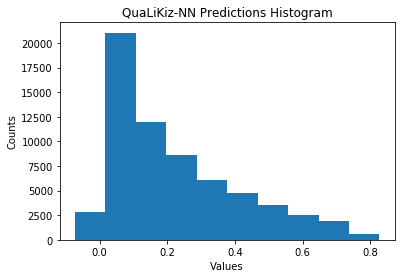

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(predictions)
plt.title('QuaLiKiz-NN Predictions Histogram')
plt.xlabel('Values')
plt.ylabel('Counts')
plt.savefig('./2018-05-31_Run0050b_DataSlicerPlot/NN_Predictions.png', dpi = 100)
plt.show()

# Plotting

##### Karel had two populations (thesis figure 5.1) at x=0 and y=0 where weird artifacts showed up. I didn't get anything like that (zoomed in around origin).

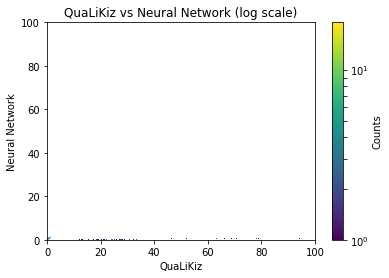

In [19]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

plt.hist2d(y_test_np_array, predictions, bins=1000, norm=LogNorm())
plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim([0, 100])
plt.xlim([0, 100])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.savefig('./2018-05-31_Run0050b_DataSlicerPlot/Zoomed-In.png', dpi = 100)
plt.show()

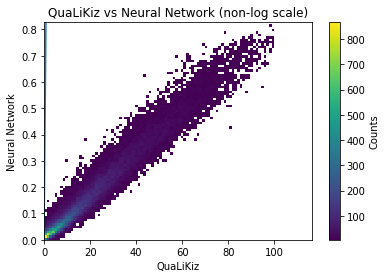

In [20]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

plt.hist2d(y_test_np_array, predictions, bins=100, cmin=5)
plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (non-log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim(0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.savefig('./2018-05-31_Run0050b_DataSlicerPlot/QuaLiKiz-vs-NN_nonLogScale_bins100.png', dpi = 100)
plt.show()

In [21]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

plt.hist2d(y_test_np_array, predictions, bins=350, cmin=6)
plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (non-log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim([0, 0.3])
plt.xlim([0, 0.3])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.savefig('./2018-05-31_Run0050b_DataSlicerPlot/QuaLiKiz-vs-NN_nonLogScale_ZoomedIn.png', dpi = 100)
plt.show()

ValueError: Image size of 103899x665 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 2 Axes>

# Plotting non-normalized values

In [22]:
print(type(predictions))
print(predictions.max(), predictions.min())

<class 'numpy.ndarray'>
0.826623 -0.0722304


In [23]:
print(predictions.shape)

(63888,)


In [24]:
predictions_nonNormalized = predictions*116.856499
print(predictions_nonNormalized)

[ 86.03089142   7.66789246  29.64015388 ...,  74.0457077   34.63958359
  28.39328003]


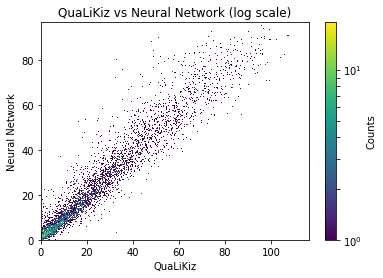

In [25]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

plt.hist2d(y_test_np_array, predictions_nonNormalized, bins=1000, norm=LogNorm())
plt.title('QuaLiKiz vs Neural Network (log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim(0)
plt.xlim(0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.savefig('./2018-05-31_Run0050b_DataSlicerPlot/QuaLiKiz-vs-NN_logScale_bins1000.png', dpi = 100)
plt.show()

C:\Users\danie\Anaconda3\lib\site-packages\matplotlib\colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


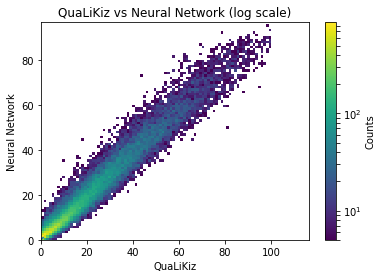

In [26]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

plt.hist2d(y_test_np_array, predictions_nonNormalized, bins=100, norm=LogNorm(), cmin=5)
plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim(0)
plt.xlim(0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.savefig('./2018-05-31_Run0050b_DataSlicerPlot/QuaLiKiz-vs-NN_logScale_bins100.png', dpi = 100)
plt.show()

In [27]:
joined_dataFrame.head()

,efeETG_GB,Ati,Ate,An,qx,smag,x,Ti_Te
978721,1.698403,1.000000e-14,2.75,1.0,1.0,0.4,0.84,2.5
981745,0.848584,1.000000e-14,2.75,1.0,1.5,0.1,0.84,2.5
981787,2.298091,1.000000e-14,2.75,1.0,1.5,0.1,0.99,2.5
985063,0.492831,1.000000e-14,2.75,1.0,2.0,0.1,0.69,2.5
985105,2.069086,1.000000e-14,2.75,1.0,2.0,0.1,0.84,2.5


In [28]:
joined_dataFrame.describe(include='all')

,efeETG_GB,Ati,Ate,An,qx,smag,x,Ti_Te
count,638880.000000,6.388800e+05,638880.000000,638880.000000,638880.000000,638880.000000,638880.000000,638880.000000
mean,26.038572,5.439559e+00,8.509738,2.075249,4.355203,0.464310,0.483960,1.375224
std,22.899494,2.943392e+00,3.025638,1.693567,4.230269,1.157654,0.286345,0.675178
min,0.015788,1.000000e-14,2.000000,-5.000000,0.660000,-1.000000,0.090000,0.250000
25%,7.663502,3.500000e+00,6.500000,1.000000,1.500000,0.100000,0.210000,0.750000
50%,19.125839,5.000000e+00,8.000000,2.000000,2.500000,0.400000,0.450000,1.330000
75%,38.814079,7.250000e+00,10.000000,3.000000,5.000000,1.000000,0.690000,1.660000
max,116.856499,1.400000e+01,14.000000,6.000000,15.000000,5.000000,0.990000,2.500000


In [29]:
joined_dataFrame.to_csv('./out.csv', encoding='utf-8')

C:\Users\danie\Anaconda3\lib\site-packages\matplotlib\colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


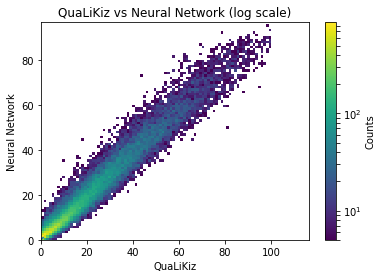

In [30]:
# plt.xkcd()
plt.hist2d(y_test_np_array, predictions_nonNormalized, bins=100, norm=LogNorm(), cmin=5)
plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim(0)
plt.xlim(0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.savefig('./2018-05-31_Run0050b_DataSlicerPlot/QuaLiKiz-vs-NN_logScale_bins100.png', dpi = 100)
plt.show()

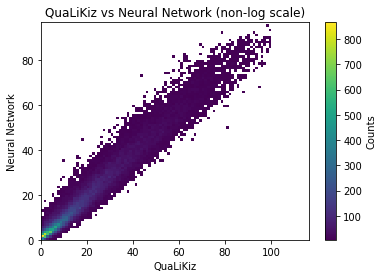

In [31]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

plt.hist2d(y_test_np_array, predictions_nonNormalized, bins=100, cmin=5)
plt.plot( [0,1],[0,1] )
plt.title('QuaLiKiz vs Neural Network (non-log scale)')
plt.xlabel('QuaLiKiz')
plt.ylabel('Neural Network')
plt.ylim(0)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.savefig('./2018-05-31_Run0050b_DataSlicerPlot/QuaLiKiz-vs-NN_nonLogScale_bins100.png', dpi = 100)
plt.show()

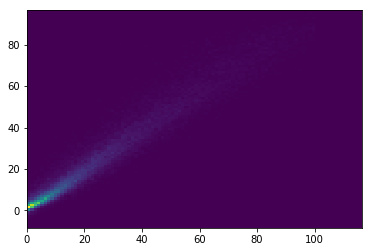

In [32]:
h = plt.hist2d(y_test_np_array, predictions_nonNormalized,bins = 100)


In [33]:
print(h)

(array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([  1.85161401e-02,   1.18143189e+00,   2.34434772e+00,
         3.50726366e+00,   4.67017937e+00,   5.83309507e+00,
         6.99601078e+00,   8.15892696e+00,   9.32184219e+00,
         1.04847584e+01,   1.16476746e+01,   1.28105898e+01,
         1.39735060e+01,   1.51364212e+01,   1.62993374e+01,
         1.74622536e+01,   1.86251698e+01,   1.97880840e+01,
         2.09510002e+01,   2.21139164e+01,   2.32768326e+01,
         2.44397488e+01,   2.56026630e+01,   2.67655792e+01,
         2.79284954e+01,   2.90914116e+01,   3.02543278e+01,
         3.14172421e+01,   3.25801582e+01,   3.37430763e+01,
         3.49059906e+01,   3.60689049e+01,   3.72318230e+01,
         3.83947372e+01,   3.95576553e+01,   4.07

In [34]:
print(h[0])

[[ 0.  1.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [35]:
sigmas = []
Qualikiz = y_test_np_array
for i in range(len(h[0])):
    sigmas.append(numpy.std(h[0][i] / numpy.max(h[0][i])))

C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


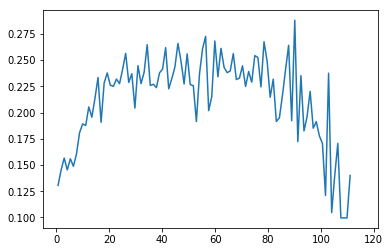

In [36]:
plt.plot((numpy.array(h[1][1:]) + numpy.array(h[1][:-1]))/2.,sigmas)

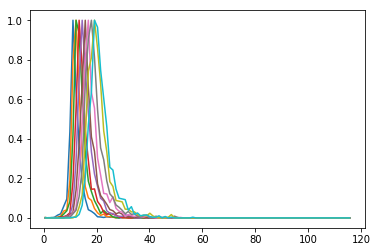

In [37]:
for i in range(10):
    plt.plot((h[1][1:] + h[1][:-1])/2., h[0][i]/numpy.max(h[0][i]) )

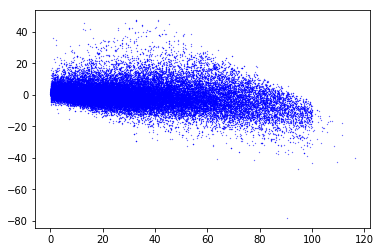

In [38]:
plt.plot(y_test_np_array, predictions_nonNormalized - y_test_np_array, 'b.', ms = 0.5)

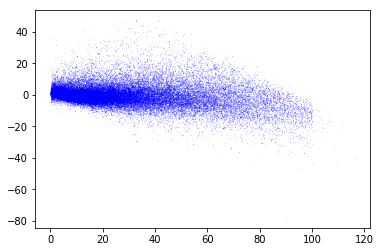

In [39]:
plt.plot(y_test_np_array, predictions_nonNormalized - y_test_np_array, 'b.', ms = 0.1)
#plt.savefig('',dpi = 600)

# Data Slicer

### Looking at Data Frames

In [40]:
print(joined_dataFrame)

          efeETG_GB           Ati    Ate   An    qx  smag     x  Ti_Te
978721     1.698403  1.000000e-14   2.75  1.0   1.0   0.4  0.84   2.50
981745     0.848584  1.000000e-14   2.75  1.0   1.5   0.1  0.84   2.50
981787     2.298091  1.000000e-14   2.75  1.0   1.5   0.1  0.99   2.50
985063     0.492831  1.000000e-14   2.75  1.0   2.0   0.1  0.69   2.50
985105     2.069086  1.000000e-14   2.75  1.0   2.0   0.1  0.84   2.50
985147     2.804335  1.000000e-14   2.75  1.0   2.0   0.1  0.99   2.50
988423     0.936546  1.000000e-14   2.75  1.0   2.5   0.1  0.69   2.50
988465     2.947697  1.000000e-14   2.75  1.0   2.5   0.1  0.84   2.50
988501     0.558062  1.000000e-14   2.75  1.0   2.5   0.1  0.99   1.66
988507     2.746332  1.000000e-14   2.75  1.0   2.5   0.1  0.99   2.50
991825     2.851121  1.000000e-14   2.75  1.0   3.0   0.1  0.84   2.50
991867     4.071063  1.000000e-14   2.75  1.0   3.0   0.1  0.99   2.50
995185     2.490547  1.000000e-14   2.75  1.0   4.0   0.1  0.84   2.50
995221

In [41]:
joined_dataFrame.Ate.describe

<bound method NDFrame.describe of 978721       2.75
981745       2.75
981787       2.75
985063       2.75
985105       2.75
985147       2.75
988423       2.75
988465       2.75
988501       2.75
988507       2.75
991825       2.75
991867       2.75
995185       2.75
995221       2.75
995227       2.75
998581       2.75
998587       2.75
1012027      2.75
1012321      2.75
1012363      2.75
1015387      2.75
1015597      2.75
1015639      2.75
1015681      2.75
1015717      2.75
1015723      2.75
1018705      2.75
1018747      2.75
1018957      2.75
1018999      2.75
            ...  
58060165    14.00
58060189    14.00
58060195    14.00
58060207    14.00
58060231    14.00
58060237    14.00
58060243    14.00
58060267    14.00
58060273    14.00
58060279    14.00
58060285    14.00
58060321    14.00
58060333    14.00
58060369    14.00
58060543    14.00
58060579    14.00
58060585    14.00
58060627    14.00
58060663    14.00
58060669    14.00
58060699    14.00
58060705    14.00
58060711    

### Masks

#### Ate

In [42]:
Ate_mask1 = joined_dataFrame.Ate == 2
Ate_mask2 = joined_dataFrame.Ate == 2.75
Ate_mask3 = joined_dataFrame.Ate == 3.5
Ate_mask4 = joined_dataFrame.Ate == 4.25
Ate_mask5 = joined_dataFrame.Ate == 5
Ate_mask6 = joined_dataFrame.Ate == 5.75
Ate_mask7 = joined_dataFrame.Ate == 6.5
Ate_mask8 = joined_dataFrame.Ate == 7.25
Ate_mask9 = joined_dataFrame.Ate == 8
Ate_mask10 = joined_dataFrame.Ate == 10
Ate_mask11 = joined_dataFrame.Ate == 14

Ate_anti_mask1 = joined_dataFrame.Ate != 2
Ate_anti_mask2 = joined_dataFrame.Ate != 2.75
Ate_anti_mask3 = joined_dataFrame.Ate != 3.5
Ate_anti_mask4 = joined_dataFrame.Ate != 4.25
Ate_anti_mask5 = joined_dataFrame.Ate != 5
Ate_anti_mask6 = joined_dataFrame.Ate != 5.75
Ate_anti_mask7 = joined_dataFrame.Ate != 6.5
Ate_anti_mask8 = joined_dataFrame.Ate != 7.25
Ate_anti_mask9 = joined_dataFrame.Ate != 8
Ate_anti_mask10 = joined_dataFrame.Ate != 10
Ate_anti_mask11 = joined_dataFrame.Ate != 14



'''
# Ate has MANY values for
2.75
3.5
4.25
5
5.75
6.5
7.25
8

# and VERY FEW values for
10
2
'''



newDF = joined_dataFrame[Ate_anti_mask1 & Ate_anti_mask2 & Ate_anti_mask3 & Ate_anti_mask4 & Ate_anti_mask5 &
                        Ate_anti_mask6 & Ate_anti_mask7]
print(newDF)

          efeETG_GB           Ati    Ate   An     qx  smag     x  Ti_Te
3293239    0.792281  1.000000e-14   7.25 -1.0   0.66   0.1  0.33   1.00
3293275    1.879505  1.000000e-14   7.25 -1.0   0.66   0.1  0.45   0.75
3293281    1.091947  1.000000e-14   7.25 -1.0   0.66   0.1  0.45   1.00
3293317    2.355931  1.000000e-14   7.25 -1.0   0.66   0.1  0.57   0.75
3293323    5.712857  1.000000e-14   7.25 -1.0   0.66   0.1  0.57   1.00
3293353    0.220907  1.000000e-14   7.25 -1.0   0.66   0.1  0.69   0.50
3293359    5.684714  1.000000e-14   7.25 -1.0   0.66   0.1  0.69   0.75
3293365    9.217609  1.000000e-14   7.25 -1.0   0.66   0.1  0.69   1.00
3293395    2.413116  1.000000e-14   7.25 -1.0   0.66   0.1  0.84   0.50
3293401    8.236678  1.000000e-14   7.25 -1.0   0.66   0.1  0.84   0.75
3293437    5.541039  1.000000e-14   7.25 -1.0   0.66   0.1  0.99   0.50
3293575    1.918382  1.000000e-14   7.25 -1.0   0.66   0.4  0.33   1.00
3293611    5.299275  1.000000e-14   7.25 -1.0   0.66   0.4  0.45

#### An

In [43]:
An_mask1 = joined_dataFrame.An == -5
An_mask2 = joined_dataFrame.An == -3
An_mask3 = joined_dataFrame.An == -1
An_mask4 = numpy.array(joined_dataFrame.An <= 1.1e-14) * numpy.array(joined_dataFrame.An >= 9E-15)
An_mask5 = joined_dataFrame.An == 0.5
An_mask6 = joined_dataFrame.An == 1.0
An_mask7 = joined_dataFrame.An == 1.5
An_mask8 = joined_dataFrame.An == 2.0
An_mask9 = joined_dataFrame.An == 2.5
An_mask10 = joined_dataFrame.An == 3.0
An_mask11 = joined_dataFrame.An == 4.0
An_mask12 = joined_dataFrame.An == 6.0

An_anti_mask1 = joined_dataFrame.An != -5
An_anti_mask2 = joined_dataFrame.An != -3
An_anti_mask3 = joined_dataFrame.An != -1
An_anti_mask4 = joined_dataFrame.An != 9.9999998245167E-15
An_anti_mask5 = joined_dataFrame.An != 0.5
An_anti_mask6 = joined_dataFrame.An != 1.0
An_anti_mask7 = joined_dataFrame.An != 1.5
An_anti_mask8 = joined_dataFrame.An != 2.0
An_anti_mask9 = joined_dataFrame.An != 2.5
An_anti_mask10 = joined_dataFrame.An != 3.0
An_anti_mask11 = joined_dataFrame.An != 4.0
An_anti_mask12 = joined_dataFrame.An != 6.0


newDF = joined_dataFrame[An_anti_mask1 & An_anti_mask2 & An_anti_mask3 & An_anti_mask4 & An_anti_mask5 &
                        An_anti_mask6 & An_anti_mask7 & An_anti_mask8 & An_anti_mask9 & An_anti_mask10 &
                        An_anti_mask11 & An_anti_mask12]

print(newDF)

Empty DataFrame
Columns: [efeETG_GB, Ati, Ate, An, qx, smag, x, Ti_Te]
Index: []


#### Ati

In [44]:
print(An_mask4.any() == True)

True


In [45]:
Ati_mask1 = numpy.array(joined_dataFrame.Ati <= 1.1e-14) * numpy.array(joined_dataFrame.Ati >= 9E-15)
Ati_mask2 = joined_dataFrame.Ati == 2
Ati_mask3 = joined_dataFrame.Ati == 2.75
Ati_mask4 = joined_dataFrame.Ati == 3.5
Ati_mask5 = joined_dataFrame.Ati == 4.25
Ati_mask6 = joined_dataFrame.Ati == 5
Ati_mask7 = joined_dataFrame.Ati == 5.75
Ati_mask8 = joined_dataFrame.Ati == 6.5
Ati_mask9 = joined_dataFrame.Ati == 7.25
Ati_mask10 = joined_dataFrame.Ati == 8
Ati_mask11 = joined_dataFrame.Ati == 10
Ati_mask12 = joined_dataFrame.Ati == 14

newDF = joined_dataFrame[Ati_mask1]

print(newDF)

         efeETG_GB           Ati    Ate   An    qx  smag     x  Ti_Te
978721    1.698403  1.000000e-14   2.75  1.0   1.0  0.40  0.84   2.50
981745    0.848584  1.000000e-14   2.75  1.0   1.5  0.10  0.84   2.50
981787    2.298091  1.000000e-14   2.75  1.0   1.5  0.10  0.99   2.50
985063    0.492831  1.000000e-14   2.75  1.0   2.0  0.10  0.69   2.50
985105    2.069086  1.000000e-14   2.75  1.0   2.0  0.10  0.84   2.50
985147    2.804335  1.000000e-14   2.75  1.0   2.0  0.10  0.99   2.50
988423    0.936546  1.000000e-14   2.75  1.0   2.5  0.10  0.69   2.50
988465    2.947697  1.000000e-14   2.75  1.0   2.5  0.10  0.84   2.50
988501    0.558062  1.000000e-14   2.75  1.0   2.5  0.10  0.99   1.66
988507    2.746332  1.000000e-14   2.75  1.0   2.5  0.10  0.99   2.50
991825    2.851121  1.000000e-14   2.75  1.0   3.0  0.10  0.84   2.50
991867    4.071063  1.000000e-14   2.75  1.0   3.0  0.10  0.99   2.50
995185    2.490547  1.000000e-14   2.75  1.0   4.0  0.10  0.84   2.50
995221    1.611633  

#### qx

In [46]:
qx_mask0 = numpy.array(joined_dataFrame.qx <= 0.67) * numpy.array(joined_dataFrame.qx >= 0.65)  #0.660000026226043
qx_mask1 = joined_dataFrame.qx == 1.0
qx_mask2 = joined_dataFrame.qx == 1.5
qx_mask3 = joined_dataFrame.qx == 2.0
qx_mask4 = joined_dataFrame.qx == 2.5
qx_mask5 = joined_dataFrame.qx == 3.0
qx_mask6 = joined_dataFrame.qx == 4.0
qx_mask7 = joined_dataFrame.qx == 5.0
qx_mask8 = joined_dataFrame.qx == 10.00
qx_mask9 = joined_dataFrame.qx == 15.00

qx_anti_mask0 = joined_dataFrame.qx != 0.660000026226043    # NOT WORKING!!!!
qx_anti_mask1 = joined_dataFrame.qx != 1.0
qx_anti_mask2 = joined_dataFrame.qx != 1.5
qx_anti_mask3 = joined_dataFrame.qx != 2.0
qx_anti_mask4 = joined_dataFrame.qx != 2.5
qx_anti_mask5 = joined_dataFrame.qx != 3.0
qx_anti_mask6 = joined_dataFrame.qx != 4.0
qx_anti_mask7 = joined_dataFrame.qx != 5.0
qx_anti_mask8 = joined_dataFrame.qx != 10.00
qx_anti_mask9 = joined_dataFrame.qx != 15.00


newDF = joined_dataFrame[qx_anti_mask1 & qx_anti_mask2 & qx_anti_mask3 & qx_anti_mask4 & qx_anti_mask5 &
                        qx_anti_mask6 & qx_anti_mask7 & qx_anti_mask8 & qx_anti_mask9 & qx_anti_mask0]

print(newDF)
# print(qx_anti_mask0)

          efeETG_GB           Ati    Ate            An    qx  smag     x  \
1344583    0.399100  1.000000e-14   3.50  5.000000e-01  0.66  0.10  0.69   
1344625    1.188944  1.000000e-14   3.50  5.000000e-01  0.66  0.10  0.84   
1344655    0.553208  1.000000e-14   3.50  5.000000e-01  0.66  0.10  0.99   
1344661    1.928099  1.000000e-14   3.50  5.000000e-01  0.66  0.10  0.99   
1344667    2.464016  1.000000e-14   3.50  5.000000e-01  0.66  0.10  0.99   
1378225    3.263562  1.000000e-14   3.50  1.000000e+00  0.66  0.10  0.84   
1378255    0.298326  1.000000e-14   3.50  1.000000e+00  0.66  0.10  0.99   
1378267    3.917254  1.000000e-14   3.50  1.000000e+00  0.66  0.10  0.99   
1378519    4.676489  1.000000e-14   3.50  1.000000e+00  0.66  0.40  0.69   
1378597    0.512905  1.000000e-14   3.50  1.000000e+00  0.66  0.40  0.99   
1411783    0.408318  1.000000e-14   3.50  1.500000e+00  0.66  0.10  0.69   
1411819    0.121346  1.000000e-14   3.50  1.500000e+00  0.66  0.10  0.84   
1411825    1

#### smag

In [74]:
smag_mask1 = joined_dataFrame.smag == -1.0
smag_mask2 = numpy.array(joined_dataFrame.smag <= 0.11) * numpy.array(joined_dataFrame.smag >= 0.09)   # 0.100000001490116
smag_mask3 = numpy.array(joined_dataFrame.smag <= 0.41) * numpy.array(joined_dataFrame.smag >= 0.39)   # 0.400000005960464
smag_mask4 = numpy.array(joined_dataFrame.smag <= 0.71) * numpy.array(joined_dataFrame.smag >= 0.68)   # 0.699999988079071
smag_mask5 = joined_dataFrame.smag == 1
smag_mask6 = joined_dataFrame.smag == 1.5
smag_mask7 = joined_dataFrame.smag == 2.0
smag_mask8 = joined_dataFrame.smag == 2.75
smag_mask9 = joined_dataFrame.smag == 3.5
smag_mask10 = joined_dataFrame.smag == 5.0

smag_anti_mask1 = joined_dataFrame.smag != -1.0
smag_anti_mask2 = joined_dataFrame.smag != 0.100000001490116    # NOT WORKING!!!!!
smag_anti_mask3 = joined_dataFrame.smag != 0.400000005960464    # NOT WORKING!!!!!
smag_anti_mask4 = joined_dataFrame.smag != 0.699999988079071    # NOT WORKING!!!!!
smag_anti_mask5 = joined_dataFrame.smag != 1
smag_anti_mask6 = joined_dataFrame.smag != 1.5
smag_anti_mask7 = joined_dataFrame.smag != 2.0
smag_anti_mask8 = joined_dataFrame.smag != 2.75
smag_anti_mask9 = joined_dataFrame.smag != 3.5
smag_anti_mask10 = joined_dataFrame.smag != 5.0


newDF = joined_dataFrame[smag_anti_mask1 & smag_anti_mask2 & smag_anti_mask3 & smag_anti_mask4 &
                        smag_anti_mask5 & smag_anti_mask6 & smag_anti_mask7 & smag_anti_mask8 & smag_anti_mask9 &
                        smag_anti_mask10]

print(newDF)

# joined_dataFrame.to_csv('./joined_dataFrame.csv', encoding='utf-8')
newDF.to_csv('./out_smag.csv', encoding='utf-8')

          efeETG_GB           Ati    Ate   An    qx  smag     x  Ti_Te
978721     1.698403  1.000000e-14   2.75  1.0   1.0   0.4  0.84   2.50
981745     0.848584  1.000000e-14   2.75  1.0   1.5   0.1  0.84   2.50
981787     2.298091  1.000000e-14   2.75  1.0   1.5   0.1  0.99   2.50
985063     0.492831  1.000000e-14   2.75  1.0   2.0   0.1  0.69   2.50
985105     2.069086  1.000000e-14   2.75  1.0   2.0   0.1  0.84   2.50
985147     2.804335  1.000000e-14   2.75  1.0   2.0   0.1  0.99   2.50
988423     0.936546  1.000000e-14   2.75  1.0   2.5   0.1  0.69   2.50
988465     2.947697  1.000000e-14   2.75  1.0   2.5   0.1  0.84   2.50
988501     0.558062  1.000000e-14   2.75  1.0   2.5   0.1  0.99   1.66
988507     2.746332  1.000000e-14   2.75  1.0   2.5   0.1  0.99   2.50
991825     2.851121  1.000000e-14   2.75  1.0   3.0   0.1  0.84   2.50
991867     4.071063  1.000000e-14   2.75  1.0   3.0   0.1  0.99   2.50
995185     2.490547  1.000000e-14   2.75  1.0   4.0   0.1  0.84   2.50
995221

#### x

In [75]:
x_mask1 = numpy.array(joined_dataFrame.x <= 0.10) * numpy.array(joined_dataFrame.x >= 0.08)   # 0.09
x_mask2 = numpy.array(joined_dataFrame.x <= 0.22) * numpy.array(joined_dataFrame.x >= 0.20)   # 0.21
x_mask3 = numpy.array(joined_dataFrame.x <= 0.34) * numpy.array(joined_dataFrame.x >= 0.32)   # 0.33
x_mask4 = numpy.array(joined_dataFrame.x <= 0.46) * numpy.array(joined_dataFrame.x >= 0.44)   # 0.45
x_mask5 = numpy.array(joined_dataFrame.x <= 0.58) * numpy.array(joined_dataFrame.x >= 0.56)   # 0.57
x_mask6 = numpy.array(joined_dataFrame.x <= 0.70) * numpy.array(joined_dataFrame.x >= 0.68)   # 0.69
x_mask7 = numpy.array(joined_dataFrame.x <= 0.85) * numpy.array(joined_dataFrame.x >= 0.83)   # 0.84
x_mask8 = numpy.array(joined_dataFrame.x <= 1.00) * numpy.array(joined_dataFrame.x >= 0.98)   # 0.99

x_anti_mask1 = joined_dataFrame.x != 0.69    # NOT WORKING!!!!!
x_anti_mask2 = joined_dataFrame.x != 0.84    # NOT WORKING!!!!!
x_anti_mask3 = joined_dataFrame.x != 0.99    # NOT WORKING!!!!!


newDF = joined_dataFrame[x_anti_mask1 & x_anti_mask2 & x_anti_mask3]

print(newDF)

          efeETG_GB           Ati    Ate   An    qx  smag     x  Ti_Te
978721     1.698403  1.000000e-14   2.75  1.0   1.0   0.4  0.84   2.50
981745     0.848584  1.000000e-14   2.75  1.0   1.5   0.1  0.84   2.50
981787     2.298091  1.000000e-14   2.75  1.0   1.5   0.1  0.99   2.50
985063     0.492831  1.000000e-14   2.75  1.0   2.0   0.1  0.69   2.50
985105     2.069086  1.000000e-14   2.75  1.0   2.0   0.1  0.84   2.50
985147     2.804335  1.000000e-14   2.75  1.0   2.0   0.1  0.99   2.50
988423     0.936546  1.000000e-14   2.75  1.0   2.5   0.1  0.69   2.50
988465     2.947697  1.000000e-14   2.75  1.0   2.5   0.1  0.84   2.50
988501     0.558062  1.000000e-14   2.75  1.0   2.5   0.1  0.99   1.66
988507     2.746332  1.000000e-14   2.75  1.0   2.5   0.1  0.99   2.50
991825     2.851121  1.000000e-14   2.75  1.0   3.0   0.1  0.84   2.50
991867     4.071063  1.000000e-14   2.75  1.0   3.0   0.1  0.99   2.50
995185     2.490547  1.000000e-14   2.75  1.0   4.0   0.1  0.84   2.50
995221

#### Ti_Te

In [76]:
Ti_Te_mask1 = joined_dataFrame.Ti_Te == 0.25
Ti_Te_mask2 = joined_dataFrame.Ti_Te == 0.5
Ti_Te_mask3 = joined_dataFrame.Ti_Te == 0.75
Ti_Te_mask4 = joined_dataFrame.Ti_Te == 1
Ti_Te_mask5 = numpy.array(joined_dataFrame.Ti_Te <= 1.34) * numpy.array(joined_dataFrame.Ti_Te >= 1.32)   # 1.33
numpy.array(joined_dataFrame.Ti_Te <= 1.67) * numpy.array(joined_dataFrame.Ti_Te >= 1.65)   # 1.66
Ti_Te_mask7 = joined_dataFrame.Ti_Te == 2.50

Ti_Te_anti_mask0 = joined_dataFrame.Ti_Te != 1.66    # NOT WORKING!!!!!!
Ti_Te_anti_mask1 = joined_dataFrame.Ti_Te != 2.50

# newDF = joined_dataFrame[Ti_Te_mask0 & Ti_Te_mask05]

print(newDF)

          efeETG_GB           Ati    Ate   An    qx  smag     x  Ti_Te
978721     1.698403  1.000000e-14   2.75  1.0   1.0   0.4  0.84   2.50
981745     0.848584  1.000000e-14   2.75  1.0   1.5   0.1  0.84   2.50
981787     2.298091  1.000000e-14   2.75  1.0   1.5   0.1  0.99   2.50
985063     0.492831  1.000000e-14   2.75  1.0   2.0   0.1  0.69   2.50
985105     2.069086  1.000000e-14   2.75  1.0   2.0   0.1  0.84   2.50
985147     2.804335  1.000000e-14   2.75  1.0   2.0   0.1  0.99   2.50
988423     0.936546  1.000000e-14   2.75  1.0   2.5   0.1  0.69   2.50
988465     2.947697  1.000000e-14   2.75  1.0   2.5   0.1  0.84   2.50
988501     0.558062  1.000000e-14   2.75  1.0   2.5   0.1  0.99   1.66
988507     2.746332  1.000000e-14   2.75  1.0   2.5   0.1  0.99   2.50
991825     2.851121  1.000000e-14   2.75  1.0   3.0   0.1  0.84   2.50
991867     4.071063  1.000000e-14   2.75  1.0   3.0   0.1  0.99   2.50
995185     2.490547  1.000000e-14   2.75  1.0   4.0   0.1  0.84   2.50
995221

In [77]:
store = pandas.HDFStore("../IPP-Neural-Networks/unstable_training_gen2_7D_nions0_flat_filter7.h5")
target_df = store['efeETG_GB'].to_frame()  # This one is relatively easy to train
test_input_df = store['efeETG_GB']
test_input_df2 = store.info

### Plots

In [88]:
'''
{'An': 3,
'Ati': 5.75,
'Ti_Te': 1.33,
'q': 3,
'smag': 0.7,
'x': 0.45}
'''

newDF = joined_dataFrame[An_mask10 & Ati_mask7 & qx_mask5 & smag_mask4 & x_mask4 & Ti_Te_mask5]  # Variable Ate
print(newDF)
print(type(newDF))

          efeETG_GB   Ati   Ate   An   qx  smag     x  Ti_Te
30963559   7.413384  5.75  4.25  3.0  3.0   0.7  0.45   1.33
31366759  13.286460  5.75  5.00  3.0  3.0   0.7  0.45   1.33
32576359  63.699650  5.75  7.25  3.0  3.0   0.7  0.45   1.33
<class 'pandas.core.frame.DataFrame'>


In [86]:
efeETG_DF = newDF['efeETG_GB']
efeETG_DF_np_array = efeETG_DF.values
print(efeETG_DF_np_array)

Ate_DF = newDF['Ate']
Ate_DF_np_array = Ate_DF.values
print(Ate_DF_np_array)

[  7.41338396  13.28645992  63.69964981]
[ 4.25  5.    7.25]


In [80]:
An_mask10 & Ati_mask7 & qx_mask5 & smag_mask4 & x_mask4 & Ti_Te_mask5

print(An_mask10.any() == True)
print(Ati_mask7.any() == True)
print(qx_mask5.any() == True)
print(smag_mask4.any() == True)
print(x_mask4.any() == True)
print(Ti_Te_mask5.any() == True)

True
True
True
True
True
True


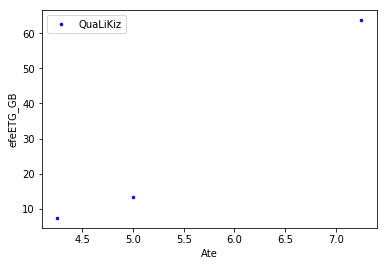

In [121]:
efeETG_DF = newDF['efeETG_GB']
Ate_DF = newDF['Ate']
plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

# Add neural network predictions

In [91]:
predictions

ValueError: No axis named 9 for object type <class 'pandas.core.frame.DataFrame'>

In [96]:
print(type(predictions_nonNormalized))

<class 'numpy.ndarray'>


In [98]:
predictions_DF = pandas.DataFrame(predictions_nonNormalized)

In [99]:
print(type(predictions_DF))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
predictions = new_model.predict(x_test_np_array_normalized, batch_size = 10, verbose=0)
print(type(predictions))

predictions = predictions.flatten()
print(predictions.shape)
print(type(predictions))

In [101]:
print(x_test_np_array_normalized.shape)

(63888, 7)


In [107]:
20**6

64000000

In [142]:
table = numpy.zeros((200,7))

In [143]:
table[:,0] = 5.75    # Ati
table[:,1] = numpy.linspace(2,14,200)   # Ate
table[:,2] = 3       # An
table[:,3] = 3       # qx
table[:,4] = 0.7     # smag
table[:,5] = 0.45    # x
table[:,6] = 1.33    # Ti_Te

In [144]:
table

array([[  5.75      ,   2.        ,   3.        , ...,   0.7       ,
          0.45      ,   1.33      ],
       [  5.75      ,   2.06030151,   3.        , ...,   0.7       ,
          0.45      ,   1.33      ],
       [  5.75      ,   2.12060302,   3.        , ...,   0.7       ,
          0.45      ,   1.33      ],
       ..., 
       [  5.75      ,  13.87939698,   3.        , ...,   0.7       ,
          0.45      ,   1.33      ],
       [  5.75      ,  13.93969849,   3.        , ...,   0.7       ,
          0.45      ,   1.33      ],
       [  5.75      ,  14.        ,   3.        , ...,   0.7       ,
          0.45      ,   1.33      ]])

In [165]:
new_predictions = new_model.predict(table, batch_size = 10, verbose=0)
print(type(new_predictions))
new_predictions = new_predictions.flatten()

<class 'numpy.ndarray'>


In [166]:
print(new_predictions.shape)

(200,)


In [167]:
new_predictions.max()

0.68566006

In [164]:
new_predictions = new_predictions['efeETG_GB']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

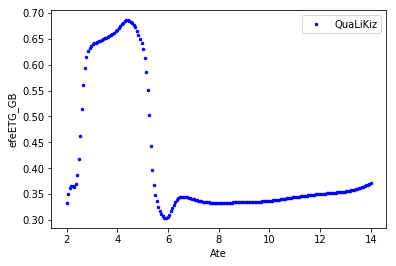

In [148]:
efeETG_DF = newDF['efeETG_GB']
Ate_DF = newDF['Ate']
plt.plot(table[:,1], new_predictions, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

In [149]:
# Normalizes data (no standardization necessary due to dataset design)
table_normalized = table/table.max().astype(numpy.float64)

In [150]:
new_predictions_normalized = new_model.predict(table_normalized, batch_size = 10, verbose=0)

In [160]:
new_predictions_normalized.max()

0.16473919

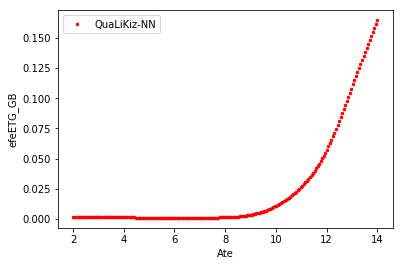

In [151]:
efeETG_DF = newDF['efeETG_GB']
Ate_DF = newDF['Ate']
plt.plot(table[:,1], new_predictions_normalized, 'r.', ms = 5, label = 'QuaLiKiz-NN')
# plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

In [157]:
# De-Normalizes the neural network predictions
new_predictions_de_normalized = new_predictions_normalized*116.856499    # table.max().astype(numpy.float64)
print(new_predictions_de_normalized.max())

19.2508


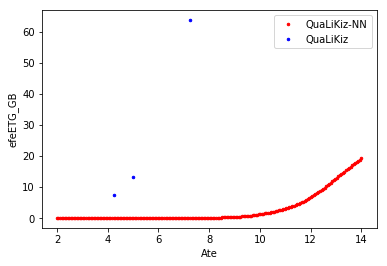

In [158]:
efeETG_DF = newDF['efeETG_GB']
Ate_DF = newDF['Ate']
plt.plot(table[:,1], new_predictions_de_normalized, 'r.', ms = 5, label = 'QuaLiKiz-NN')
plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.legend()
plt.show()

In [168]:
60/0.15

400.0

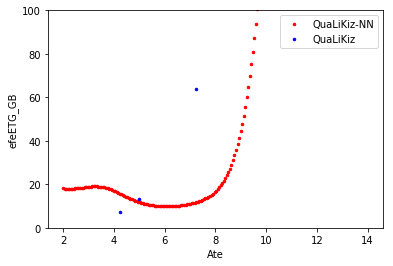

In [171]:
efeETG_DF = newDF['efeETG_GB']
Ate_DF = newDF['Ate']
plt.plot(table[:,1], new_predictions_de_normalized*116.856499, 'r.', ms = 5, label = 'QuaLiKiz-NN')
plt.plot(Ate_DF_np_array, efeETG_DF_np_array, 'b.', ms = 5, label = 'QuaLiKiz')
plt.xlabel('Ate')
plt.ylabel('efeETG_GB')
plt.ylim(0, 100)
plt.legend()
plt.show()